In [1]:
import xarray as xr
import dask
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import scipy
from scipy import signal
from scipy.optimize import curve_fit
import math
import statistics 
from scipy.stats.kde import gaussian_kde
from numpy import linspace

In [2]:
#R2 = np.load('/fast/gmooers/RG_Paper_Data/15_Min_Interval_Heat.npy')
R2 = np.load('/fast/gmooers/Real_Geography_Manuscript/Data_For_Paper/April_SPCAM5_15_Min_Interval_Heat.npy')
thresh = 0
super_threshold_indices = R2 < thresh
R2[super_threshold_indices] = 0
thresh = 1
super_threshold_indices = R2 > thresh
R2[super_threshold_indices] = 1

Tropical_R = R2[:,40:55,:]
Mid_R = R2[:,64:80,:]

#path_to_file = '/fast/gmooers/Preprocessed_Data/7_Years_Spaced/full_physics_essentials_valid_month02_targets.nc'
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/One_Month_Apr/full_physics_essentials_valid_month02_targets.nc'
extra_variables = xr.open_dataset(path_to_file)
truths = extra_variables.targets[:,:30].values

#path_to_file = '/fast/gmooers/Models/Jordan_Best.nc'
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Good_Apr.nc'
extra_variables = xr.open_dataset(path_to_file)
predictions = extra_variables.Prediction[:,:30].values

x = 144
y = 96
segment = x*y
z = 30
t = int(len(truths)/(x*y))
print(t)
reconstructed_targets = np.zeros(shape=(x, y, t, z))
reconstructed_features = np.zeros(shape=(x, y, t, z))

2879


In [3]:
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            A = truths[count,:]
            B = predictions[count,:]
            reconstructed_targets[k, j, i, :] = A
            reconstructed_features[k, j, i, :] = B
            count = count+1
            
print(reconstructed_targets.shape)
print(reconstructed_features.shape)

(144, 96, 2879, 30)
(144, 96, 2879, 30)


In [4]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.81 #m/s^2
#print(plev)
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
#print(hyai.shape)
#print(hyai)
cp = 1004.0
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
dp = P[1:]-P[:-1] # Differential pressure [Pa]
#convert from k/s to w/m^2
reconstructed_targets = reconstructed_targets*dp[None, None, None, :]*cp/g
reconstructed_features = reconstructed_features*dp[None, None, None, :]*cp/g
print('made it')

lat_list = np.linspace(-90.0, 90.0, 96)
lon_list = np.linspace(0.0, 357.5, 144)

#method 1 - Hovmueller Github 
a = 6.37e6 #radius of the earth
dlat = np.abs(lat_list[1]-lat_list[0])
dlon = np.abs(lon_list[0]-lon_list[1])
gridCellWidth = (dlon*np.pi/180.)*a*np.cos(lat_list*np.pi/180.)
reconstructed_targets = reconstructed_targets*gridCellWidth[None,:,None,None]
reconstructed_features = reconstructed_features*gridCellWidth[None,:,None,None]

made it


Function to analyse original time series

In [5]:
def plotting(true, guess, name):
    plt.plot(true, label = 'Truth')
    plt.plot(guess, label = 'Prediction')
    plt.legend()
    plt.xlabel('Days of the Year', fontsize = 20)
    plt.ylabel('Heat Rate in K/s', fontsize = 20)
    #plt.ylim(bottom, top)
    plt.title('Time series for '+name+' location')

Function to get e folding time scale from reconstructed data

In [6]:
def Signal_Test(point_a, point_b, labels):
    fig, ax = plt.subplots()
    plt.title(labels)
    tcoor = np.arange(0, len(point_b), 1)/96
    plt.plot(tcoor, point_a, label="Truth", color = 'blue')
    plt.plot(tcoor, point_b, label = "Prediction", color = 'green')
    it = np.argwhere(np.diff(np.sign(point_a/point_a[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_a[0], s=100, marker = 'H', color = 'orange', label="Truth e-folding Distance: "+str(round(tau[0],2))+ ' days')
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_b[0], s=100, marker = 'H', color = 'red', label="Predicted e-folding Distance: "+str(round(tau[0],2))+ ' days')
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.show()
    plt.close()

Function to reconstruct and deconstruct time series for anaylsis

In [7]:
def AutoCorr_Point(a):
    a = np.concatenate((a,np.zeros(len(a)-1)))
    A = np.fft.fft(a)
    S = np.conj(A)*A
    c_fourier = np.fft.ifft(S)
    c_fourier = c_fourier[:(c_fourier.size//2)+1]
    return c_fourier

In [8]:
def field_generator_x(truths, preds):
    corr_truth = np.zeros(shape=(x,y,t,z))
    corr_truth[:,:,:,:] = np.nan
    corr_pred = np.zeros(shape=(x,y,t,z))
    corr_pred[:,:,:,:] = np.nan
    for i in range(len(corr_truth[0][0])):
        for j in range(len(corr_truth[0])):
            for k in range(len(corr_truth[0][0][0])):
                truth_fourier = AutoCorr_Point(truths[:,j,i,k])
                pred_fourier = AutoCorr_Point(preds[:,j,i,k])
                corr_truth[:,j,i,k] = truth_fourier/np.max(truth_fourier)
                corr_pred[:,j,i,k] = pred_fourier/np.max(pred_fourier)
        if i%100==0:
            print(i)
    
    return corr_truth, corr_pred

In [9]:
def field_generator_y(truths, preds):
    corr_truth = np.zeros(shape=(x,y,t,z))
    corr_truth[:,:,:,:] = np.nan
    corr_pred = np.zeros(shape=(x,y,t,z))
    corr_pred[:,:,:,:] = np.nan
    for i in range(len(corr_truth)):
        for j in range(len(corr_truth[0][0])):
            for k in range(len(corr_truth[0][0][0])):
                truth_fourier = AutoCorr_Point(truths[i,:,j,k])
                pred_fourier = AutoCorr_Point(preds[i,:,j,k])
                corr_truth[i,:,j,k] = truth_fourier/np.max(truth_fourier)
                corr_pred[i,:,j,k] = pred_fourier/np.max(pred_fourier)
        if i%10==0:
            print(i)
    
    return corr_truth, corr_pred

In [10]:
x_corr_truth, x_corr_pred = field_generator_x(reconstructed_targets, reconstructed_features)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  if sys.path[0] == '':


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800


In [11]:
#y_corr_truth, y_corr_pred = field_generator_y(reconstructed_targets, reconstructed_features)

In [13]:
print(x_corr_truth.shape)
#print(y_corr_truth.shape)

(144, 96, 2879, 30)


## Break into regions, and break down further by skill score

In [14]:
#tropical_truths = np.squeeze(corr_truth[:, 40:55, :,:])
#tropical_preds = np.squeeze(corr_pred[:, 40:55, :,:])

#midlat_truths = np.squeeze(corr_truth[:, 64:80, :,:])
#midlat_preds = np.squeeze(corr_pred[:, 64:80, :,:])

In [15]:
def skill_array_generator(data_array, R_array):
    poor_output_array = np.zeros(shape=(x, len(data_array[0]),t, z))
    poor_output_array[:,:,:,:] = np.nan
    good_output_array = np.zeros(shape=(x, len(data_array[0]),t, z))
    good_output_array[:,:,:,:] = np.nan
    good_count = 0
    bad_count = 0
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            for k in range(len(data_array[i][j][0])):
                if R_array[i,j,k] >= 0.7:
                    good_output_array[i,j,:,k]=data_array[i,j,:,k]
                    if k == len(data_array[i][j][0]) -1:
                        good_count = good_count+1
                
                if R_array[i,j,k] < 0.3:
                    poor_output_array[i,j,:,k]=data_array[i,j,:,k]
                    if k == len(data_array[i][j][0]) -1:
                        bad_count = bad_count+1
     
    print("Skilled Count is:", good_count, "Unskilled Count is:", bad_count, "Total_Count is:", 144*len(data_array[0]))
    return good_output_array, poor_output_array  

In [16]:
print(R2.shape)

(144, 96, 30)


In [17]:
x_all_good_truths, x_all_bad_truths = skill_array_generator(x_corr_truth, np.squeeze(R2))
x_all_good_preds, x_all_bad_preds = skill_array_generator(x_corr_pred, np.squeeze(R2))

#y_all_good_truths, y_all_bad_truths = skill_array_generator(x_corr_truth, np.squeeze(R2))
#y_all_good_preds, y_all_bad_preds = skill_array_generator(x_corr_pred, np.squeeze(R2))







Skilled Count is: 7343 Unskilled Count is: 1567 Total_Count is: 13824
Skilled Count is: 7343 Unskilled Count is: 1567 Total_Count is: 13824


In [21]:
R_surface =np.squeeze(np.squeeze(R2)[:,:,-1])

In [18]:
def histo(feats, name):
    f = feats.ravel()
    num_bins = 100
    #change bin specification
    hist, bins = np.histogram(f, num_bins, normed=True)
    bin_centers = (bins[1:]+bins[:-1])*0.5
    plt.plot(bin_centers, hist, label = 'R2 Skill')
    plt.legend(loc='best')
    #plt.xlim(0)
    plt.xlabel('Skill Score', fontsize = 15)
    plt.ylabel('Frequency', fontsize = 15)
    plt.title(name, fontsize = 15)
    #plt.yscale('log')
    #plt.xscale('log')
    #plt.savefig('Figures/Original_Precip_Histogram_1000.png')
    plt.show()

title = "Histogram of R2"
#histo(R_surface, title)

## Make a PDF

In [19]:
def new_pdf(values, titles):
    R_ravel = values.ravel()
    # this create the kernel, given an array it will estimate the probability over that values
    kde = gaussian_kde(R_ravel)
    # these are the values over wich your kernel will be evaluated
    dist_space = linspace( np.min(R_ravel), np.max(R_ravel), 100)
    plt.plot( dist_space, kde(dist_space) )
    plt.xlabel("R2 Skill Score")
    plt.ylabel("Probability Density")
    plt.title(titles)

title = "R2 PDF"
#new_pdf(R_surface, title)

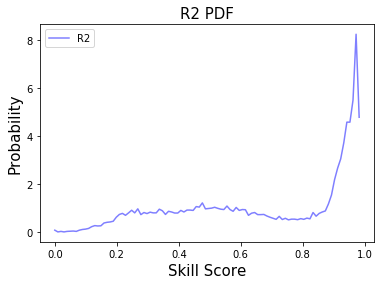

In [22]:
def pdf_gen(feat, names):
    maxi = 10.0
    bins = 100
    freq, edges = np.histogram(feat, bins, density=True)
    
    fig, ax = plt.subplots()

    plt.plot(edges[:-1], freq,  label = "R2", alpha = 0.5, color = 'blue')
    plt.xlabel('Skill Score', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.title('R2 PDF', fontsize = 15)
    plt.legend(loc = 'best')
    #plt.xscale('log')
    #plt.yscale('log')

title = "R2 PDF"    
pdf_gen(R_surface, title)

## Averaged Points to Single Time Graph

Make a single plot for the global surface

In [24]:
x_corr_pred.shape

(144, 96, 2879, 30)

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


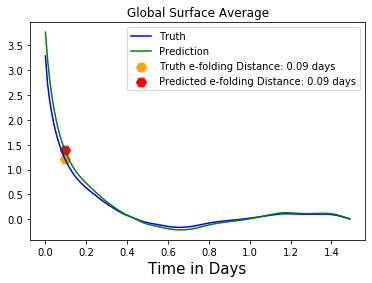

In [29]:
x_global_truth = np.squeeze(x_corr_truth[:,:,:,-1])
x_global_truth = np.nanmean(x_global_truth, axis = 1)
x_global_truth = np.nanmean(x_global_truth, axis = 1)

x_global_pred = np.squeeze(x_corr_pred[:,:,:,-1])
x_global_pred = np.nanmean(x_global_pred, axis = 1)
x_global_pred = np.nanmean(x_global_pred, axis = 1)

title = 'Global Surface Average'
truth_test = AutoCorr_Point(x_global_truth)
pred_test = AutoCorr_Point(x_global_pred)
Signal_Test(truth_test, pred_test, title)

In [37]:
def Signal_Test_Comp_Truth(point_a, title_a):
    fig, ax = plt.subplots()
    plt.title(title)
    tcoor = np.arange(0, len(point_a), 1)/96
    plt.plot(tcoor, point_a, label="All", color = 'blue')
    
    it = np.argwhere(np.diff(np.sign(point_a/point_a[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    plt.scatter(tau, np.exp(-1)*point_a[0], s=100, marker = 'H', color = 'blue', label=title_a+": "+str(round(tau[0],2))+' days')
    
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.xlim(0, 0.35)
    plt.show()
    plt.close()

IndexError: index 0 is out of bounds for axis 0 with size 0

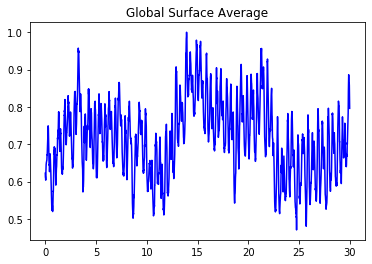

In [38]:
all_points = np.squeeze(x_corr_truth[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)



titles = 'Mid Latitude Comparison'
regions = "Mid Lats"
title_1 = 'All R'
title_2 = 'R < 0.3' 
title_3 = 'R > 0.7'
truth_test = AutoCorr_Point(x_global_truth)
pred_test = AutoCorr_Point(x_global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), title_1)

In [ ]:
all_points = np.squeeze(tropical_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.squeeze(bad_tropical_truths[:,:,:,-1])
bad_points = np.nanmean(bad_points, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.squeeze(good_tropical_truths[:,:,:,-1])
good_points = np.nanmean(good_points, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Tropical Comparison'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [ ]:
all_points = np.squeeze(corr_truth[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.squeeze(all_bad_truths[:,:,:,-1])
bad_points = np.nanmean(bad_points, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.squeeze(all_good_truths[:,:,:,-1])
good_points = np.nanmean(good_points, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Global Surface Comparison'
regions = " Global"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [ ]:
def percentile_gen(data_array, R_array):
    poor_output_array = np.zeros(shape=(x, len(data_array[0]),t))
    poor_output_array[:,:,:] = np.nan
    good_output_array = np.zeros(shape=(x, len(data_array[0]),t))
    good_output_array[:,:,:] = np.nan
    ten = np.nanpercentile(R_array, 10)
    ninty = np.nanpercentile(R_array, 90)
    good_count = 0
    bad_count = 0
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
                if R_array[i,j] >= ninty:
                    good_output_array[i,j,:]=data_array[i,j,:]
                    good_count = good_count+1
                
                if R_array[i,j] <= ten:
                    poor_output_array[i,j,:]=data_array[i,j,:]
                    bad_count = bad_count+1
     
    print("Skilled Count is:", good_count, "Unskilled Count is:", bad_count, "Total_Count is:", 144*len(data_array[0]))
    return good_output_array, poor_output_array

good_tropical_truths, bad_tropical_truths = percentile_gen(np.squeeze(tropical_truths[:,:,:,-1]), np.squeeze(np.squeeze(Tropical_R)[:,:,-1]))
good_tropical_preds, bad_tropical_preds = percentile_gen(np.squeeze(tropical_preds[:,:,:,-1]), np.squeeze(np.squeeze(Tropical_R)[:,:,-1]))
good_midlats_truths, bad_midlats_truths = percentile_gen(np.squeeze(midlat_truths[:,:,:,-1]),np.squeeze(np.squeeze(Mid_R)[:,:,-1]))
good_midlats_preds, bad_midlats_preds = percentile_gen(np.squeeze(midlat_preds[:,:,:,-1]), np.squeeze(np.squeeze(Mid_R)[:,:,-1]))
all_good_truths, all_bad_truths = percentile_gen(np.squeeze(corr_truth[:,:,:,-1]), np.squeeze(np.squeeze(R2)[:,:,-1]))
all_good_preds, all_bad_preds = percentile_gen(np.squeeze(corr_pred[:,:,:,-1]), np.squeeze(np.squeeze(R2)[:,:,-1]))

In [ ]:
all_points = np.squeeze(midlat_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(bad_midlats_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(good_midlats_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Mid Latitude Comparison'
regions = "Mid Lats"
title_1 = 'All R'
title_2 = 'Bottom 10%' 
title_3 = 'Top 10%'
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [ ]:
all_points = np.squeeze(tropical_truths[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(bad_tropical_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(good_tropical_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Tropical Comparison'
regions = "Tropics"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [ ]:
all_points = np.squeeze(corr_truth[:,:,:,-1])
all_points = np.nanmean(all_points, axis = 0)
all_points = np.nanmean(all_points, axis = 0)

bad_points = np.nanmean(all_bad_truths, axis = 0)
bad_points = np.nanmean(bad_points, axis = 0)

good_points = np.nanmean(all_good_truths, axis = 0)
good_points = np.nanmean(good_points, axis = 0)

titles = 'Global Comparison'
regions = "Global Surface"
truth_test = AutoCorr_Point(global_truth)
pred_test = AutoCorr_Point(global_pred)
Signal_Test_Comp_Truth(all_points/np.max(all_points), bad_points/np.max(bad_points), good_points/np.max(good_points), title_1, title_2, title_3, titles)

In [ ]:
def stats_gen(datas):
    q1 = []
    median = []
    q3 = []
    for i in range(len(datas[0][0])):
        temp = np.squeeze(datas[:,:,i])
        temp = temp.ravel()
        q1.append(np.nanpercentile(temp, 25))
        median.append(np.nanpercentile(temp, 50))
        q3.append(np.nanpercentile(temp, 75))
    
    q1 = np.array(q1)
    median = np.array(median)
    q3 = np.array(q3)
    
    return q1/np.max(median), median/np.max(median), q3/np.max(median)

def Sig_Test(point_b):
    tcoor = np.arange(0, len(point_b), 1)/96
    it = np.argwhere(np.diff(np.sign(point_b/point_b[0]-np.exp(-1))))[0]
    tau = tcoor[it]
    return tau[0]

def e_time_getter(data_array):
    e_times = np.zeros(shape = (x, y))
    e_times[:,:] = np.nan
    for i in range(len(data_array)):
        for j in range(len(data_array[i])):
            temp = np.squeeze(data_array[i,j,:])
            value =  Sig_Test(temp)
            e_times[i,j] = value
            
    e_data = e_times.ravel()
    filtered_data = e_data[~np.isnan(e_data)]
    return filtered_data

def plot_stats(all_array, bad_array, good_array, title):
    labels = ["All R", "Bottom 10%", "Top 10%"]
    names = ["All","Unskillful","Skillful"]
    colors = ["purple","red","blue"]
    datas = [all_array, bad_array, good_array]
    #filtered_data = e_time_getter(datas[1])
    #plt.boxplot(filtered_data)
    fig, ax = plt.subplots(figsize = (12,8))
    plt.title(title+ " IQR")
    for i in range(len(labels)):
        q1, median, q3 = stats_gen(datas[i])
        tcoor = np.arange(0, len(median), 1)/96
        if i > 0:
            #lower_bound = plt.plot(tcoor, q1, color = colors[i], linestyle='--', dashes=(5, 8), alpha=0.8)
            #upper_bound = plt.plot(tcoor, q3, color = colors[i], linestyle='--', dashes=(5, 10), alpha = 0.8)
            y = plt.plot(tcoor, median, color = colors[i])
            plt.fill_between(tcoor, q1,  q3, alpha = 0.2, color = colors[i])
            it = np.argwhere(np.diff(np.sign(median/median[0]-np.exp(-1))))[0]
            tau = tcoor[it]
            plt.scatter(tau, np.exp(-1)*median[0], s=100, marker = 'H', color = colors[i], label=labels[i]+": "+str(round(tau[0],2))+' days')
    
   
    
    plt.legend()
    plt.xlabel("Time in Days", fontsize = 15)
    plt.xlim(0, 0.40)
    plt.show()
    plt.close()
    
plot_stats(np.squeeze(midlat_truths[:,:,:,-1]), bad_midlats_truths, good_midlats_truths, "Mid Latitudes")
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Midlat_All.npy", np.squeeze(midlat_truths[:,:,:,-1]))
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Midlat_bad.npy", bad_midlats_truths)
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Midlat_good.npy", good_midlats_truths)

In [ ]:
plot_stats(np.squeeze(tropical_truths[:,:,:,-1]), bad_tropical_truths, good_tropical_truths, "Tropics")
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Tropical_All.npy", np.squeeze(tropical_truths[:,:,:,-1]))
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Tropical_bad.npy", bad_tropical_truths)
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Tropical_good.npy", good_tropical_truths)

In [ ]:
plot_stats(np.squeeze(corr_truth[:,:,:,-1]), all_bad_truths, all_good_truths, "Global_Surface")
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Surface_All.npy", np.squeeze(corr_truth[:,:,:,-1]))
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Surface_bad.npy", all_bad_truths)
#np.save("/fast/gmooers/RG_Paper_Data/Autocorr_Surface_good.npy", all_good_truths)
print("Global surface Preserved")